In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.multicomp as mc
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
import scipy.stats as stats
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import re
from joblib import dump,load

In [2]:
def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name

In [3]:
df_main=pd.read_csv(r'village_wise_survey_data_mission_antyodaya_2020.csv')

In [4]:
df_main.drop(columns=["SUB DISTRICT CODE","BLOCK CODE","GP CODE","VILLAGE CODE","VILLAGE PIN CODE","STATE NAME", "DISTRICT NAME","SUB DISTRICT NAME","BLOCK NAME","GP NAME","VILLAGE NAME","PC CODE","AC CODE","OTHER ASSEMBLY CONSTITUENCIES","NUMBER OF HOUSEHOLDS ENGAGED MAJORLY IN NON-FARM ACTIVITIES"],
             inplace=True)
df_main.head()

,STATE CODE,DISTRICT CODE,NUMBER OF TOTAL POPULATION,NUMBER OF MALE,NUMBER OF FEMALE,NUMBER OF TOTAL HOUSEHOLD,NUMBER OF HOUSEHOLDS ENGAGED MAJORLY IN FARM ACTIVITIES,AVAILABILITY OF GOVERNMENT SEED CENTRES,WHETHER THIS VILLAGE IS A PART OF THE WATERSHED DEVELOPMENT PROJECT,AVAILABILITY OF COMMUNITY RAIN WATER HARVESTING SYSTEM/POND/DAM/CHECK DAM ETC.,...,NUMBER OF FARMERS RECEIVED THE SOIL TESTING REPORT,TOTAL NUMBER OF ELECTED REPRESENTATIVES,NUMBER OF ELECTED REPRESENTATIVES ORIENTED UNDER RASHTRIYA GRAM SWARAJ ABHIYAN,NUMBER OF ELECTED REPRESENTATIVES UNDERGONE REFRESHER TRAINING UNDER RASHTRIYA GRAM SWARAJ ABHIYAN,TOTAL APPROVED LABOUR BUDGET FOR THE YEAR 2018-19,TOTAL EXPENDITURE APPROVED UNDER NRM IN THE LABOUR BUDGET FOR THE YEAR 2018-19),"TOTAL AREA COVERED UNDER IRRIGATION (DRIP, SPRINKLER), IF IN ACRES DIVIDE BY 2.47",NUMBER OF HOUSEHOLDS HAVING PIPED WATER CONNECTION,VILLAGE LATITUDE,VILLAGE LONGITUDE
0,18,294,299,139,160,68,50,No ( Nearest facility1-2 kms),No,No,...,6,8,6,4,0.0,0.0,0.0,0,26.090090,89.979380
1,18,616,4562,2366,2196,830,0,No ( Nearest facility5-10 kms),No,No,...,0,0,0,0,0.0,0.0,0.0,0,26.594595,91.641990
2,18,284,151,80,71,26,26,No ( Nearest facilityMore than 10 kms),No,No,...,0,1,0,0,0.0,0.0,0.0,0,27.747747,95.118210
3,18,300,790,431,359,233,90,No ( Nearest facilityMore than 10 kms),No,No,...,0,10,10,10,0.0,0.0,0.0,0,26.954954,94.561104
4,18,612,3050,1459,1591,780,50,No ( Nearest facility5-10 kms),No,No,...,0,0,0,0,0.0,0.0,0.0,0,26.702703,90.498500


In [5]:
cols=df_main.columns.tolist()
for i in range(len(cols)):
    if cols[i]=="DOES THE VILLAGE HAVE LIVESTOCK EXTENSION SERVICES":
        print(i)
        endcol=i

22


In [6]:
df_main.columns.to_list()

['STATE CODE',
 'DISTRICT CODE',
 'NUMBER OF TOTAL POPULATION',
 'NUMBER OF MALE',
 'NUMBER OF FEMALE',
 'NUMBER OF TOTAL HOUSEHOLD',
 'NUMBER OF HOUSEHOLDS ENGAGED MAJORLY IN FARM ACTIVITIES',
 'AVAILABILITY OF GOVERNMENT SEED CENTRES',
 'WHETHER THIS VILLAGE IS A PART OF THE WATERSHED DEVELOPMENT PROJECT',
 'AVAILABILITY OF COMMUNITY RAIN WATER HARVESTING SYSTEM/POND/DAM/CHECK DAM ETC.',
 'DOES THE VILLAGE HAS ANY FARMERS COLLECTIVE',
 'AVAILABILITY OF WAREHOUSE FOR FOOD GRAIN STORAGE ',
 'AVAILABILITY OF PRIMARY PROCESSING FACILITIES AT THE VILLAGE LEVEL ',
 'DOES THE VILLAGE HAVE ACCESS TO CUSTOM HIRING CENTRE (AGRI-EQUIPMENTS) ',
 'TOTAL CULTIVABLE AREA (IN HECTARES), IF IN ACRES DIVIDE BY 2.47',
 'NET SOWN AREA (IN HECTARES) , IF IN ACRES DIVIDE BY 2.47',
 'AVAILABILITY OF SOIL TESTING CENTRES',
 'AVAILABILITY OF FERTILIZER SHOP',
 'MAIN SOURCE OF IRRIGATION',
 'NUMBER OF FARMERS USING DRIP/SPRINKLER IRRIGATION ',
 'TOTAL AREA IRRIGATED (IN HECTARE), IF IN ACRES DIVIDE BY 2.47',


In [7]:
df=df_main.iloc[:,:endcol]

In [8]:
df.head()

,STATE CODE,DISTRICT CODE,NUMBER OF TOTAL POPULATION,NUMBER OF MALE,NUMBER OF FEMALE,NUMBER OF TOTAL HOUSEHOLD,NUMBER OF HOUSEHOLDS ENGAGED MAJORLY IN FARM ACTIVITIES,AVAILABILITY OF GOVERNMENT SEED CENTRES,WHETHER THIS VILLAGE IS A PART OF THE WATERSHED DEVELOPMENT PROJECT,AVAILABILITY OF COMMUNITY RAIN WATER HARVESTING SYSTEM/POND/DAM/CHECK DAM ETC.,...,AVAILABILITY OF PRIMARY PROCESSING FACILITIES AT THE VILLAGE LEVEL,DOES THE VILLAGE HAVE ACCESS TO CUSTOM HIRING CENTRE (AGRI-EQUIPMENTS),"TOTAL CULTIVABLE AREA (IN HECTARES), IF IN ACRES DIVIDE BY 2.47","NET SOWN AREA (IN HECTARES) , IF IN ACRES DIVIDE BY 2.47",AVAILABILITY OF SOIL TESTING CENTRES,AVAILABILITY OF FERTILIZER SHOP,MAIN SOURCE OF IRRIGATION,NUMBER OF FARMERS USING DRIP/SPRINKLER IRRIGATION,"TOTAL AREA IRRIGATED (IN HECTARE), IF IN ACRES DIVIDE BY 2.47","TOTAL UNIRRIGATED LAND AREA (IN HECTARES), IF IN ACRES DIVIDE BY 2.47"
0,18,294,299,139,160,68,50,No ( Nearest facility1-2 kms),No,No,...,No,No,3.00,Total Net sown Area :2 Kharif :2 Rabi :1.5 Oth...,No ( Nearest facility2-5 kms),No ( Nearest facility< 1 km),Other,12,1.5,1.5
1,18,616,4562,2366,2196,830,0,No ( Nearest facility5-10 kms),No,No,...,No,No,530.70,Total Net sown Area :2 Kharif :2 Rabi :2 Other :0,No ( Nearest facilityMore than 10 kms),No ( Nearest facilityMore than 10 kms),Surface water,0,0.0,0.0
2,18,284,151,80,71,26,26,No ( Nearest facilityMore than 10 kms),No,No,...,No,No,7.00,Total Net sown Area :2 Kharif :2 Rabi :2 Other :0,No ( Nearest facilityMore than 10 kms),No ( Nearest facilityMore than 10 kms),Ground water (tube well/well/pump),0,0.0,7.0
3,18,300,790,431,359,233,90,No ( Nearest facilityMore than 10 kms),No,No,...,No,No,143.47,Total Net sown Area :0 Kharif :0 Rabi :0 Other :0,No ( Nearest facilityMore than 10 kms),No ( Nearest facilityMore than 10 kms),Ground water (tube well/well/pump),0,0.0,0.0
4,18,612,3050,1459,1591,780,50,No ( Nearest facility5-10 kms),No,No,...,No,No,1.00,Total Net sown Area :0 Kharif :0 Rabi :0 Other :0,No ( Nearest facilityMore than 10 kms),No ( Nearest facility5-10 kms),Other,0,0.0,0.0


In [9]:
cols=df.columns.tolist()


df["Percentage_Of_Farming_Houses"]=df["NUMBER OF HOUSEHOLDS ENGAGED MAJORLY IN FARM ACTIVITIES"]/(df["NUMBER OF TOTAL HOUSEHOLD"])
df["DOES THE VILLAGE HAS ANY FARMERS COLLECTIVE"]=df["DOES THE VILLAGE HAS ANY FARMERS COLLECTIVE"].map({"Primary Agriculture Cooperative Society(PACS)":"PACS","Farmers Produce Organization(FPOs)":"FPO","Both":"Both"})
df["MAIN SOURCE OF IRRIGATION"]=df["MAIN SOURCE OF IRRIGATION"].map({"Ground water (tube well/well/pump)":"Ground Water","Other":"Other","Canals":"Canals","Surface Water":"Surface Water"})


In [10]:
for i in tqdm(range(len(df))):
    string = str(df["NET SOWN AREA (IN HECTARES) , IF IN ACRES DIVIDE BY 2.47"][i])
    numbers = re.findall(r'\d+\.*\d*', string)

    df.loc[i,'Area'] =numbers[0]
    df.loc[i,'Kharif'] =numbers[1]
    df.loc[i,'Rabi'] =numbers[2]
    df.loc[i,'Others'] =numbers[3]

100%|██████████| 345810/345810 [01:58<00:00, 2930.35it/s]


In [11]:
cols = ['availability of warehouse for food grain storage ','availability of soil testing centres','availability of fertilizer shop']
dic = dict(zip(df['availability of fertilizer shop'.upper()].value_counts().index.to_list(),['>10','5-10','2-5','Yes','1-2','<1']))


for col in cols:
    col=col.upper()
    df[col] = df[col].map(dic)


df=df.drop(columns="NET SOWN AREA (IN HECTARES) , IF IN ACRES DIVIDE BY 2.47")

In [12]:
cols = df.columns.to_list()
new_cols = [re.sub(r'[^a-zA-Z0-9_]' , '_', a.strip().lower()) for a in cols]
df.rename(columns=dict(zip(cols, new_cols)), inplace=True)
df.rename(columns=dict(zip(cols, new_cols)), inplace=True)
df.rename(columns={'total_area_irrigated__in_hectare___if_in_acres_divide_by_2_47': 'total_area_irrigated__in_hectare'},inplace=True)
df.rename(columns={'total_unirrigated_land_area__in_hectares___if_in_acres_divide_by_2_47': 'total_unirrigated_land_area__in_hectares'},inplace=True)

In [13]:
for col in df.columns:
    if df[col].isna().sum()!=0:
        print(col)

does_the_village_has_any_farmers_collective
main_source_of_irrigation


In [14]:
df.fillna('None',inplace=True)

In [15]:
for col in df.columns:
    if df[col].isna().sum()!=0:
        print(col)

In [16]:
df.to_csv("Agriculture.csv", index=False)

In [17]:
df=pd.read_csv("Agriculture.csv")
df.head()

,state_code,district_code,number_of_total_population,number_of_male,number_of_female,number_of_total_household,number_of_households_engaged_majorly_in_farm_activities,availability_of_government_seed_centres,whether_this_village_is_a_part_of_the_watershed_development_project,availability_of_community_rain_water_harvesting_system_pond_dam_check_dam_etc_,...,availability_of_fertilizer_shop,main_source_of_irrigation,number_of_farmers_using_drip_sprinkler_irrigation,total_area_irrigated__in_hectare,total_unirrigated_land_area__in_hectares,percentage_of_farming_houses,area,kharif,rabi,others
0,18,294,299,139,160,68,50,No ( Nearest facility1-2 kms),No,No,...,<1,Other,12,1.5,1.5,0.735294,2.0,2.0,1.5,2.0
1,18,616,4562,2366,2196,830,0,No ( Nearest facility5-10 kms),No,No,...,>10,NaN,0,0.0,0.0,0.000000,2.0,2.0,2.0,0.0
2,18,284,151,80,71,26,26,No ( Nearest facilityMore than 10 kms),No,No,...,>10,Ground Water,0,0.0,7.0,1.000000,2.0,2.0,2.0,0.0
3,18,300,790,431,359,233,90,No ( Nearest facilityMore than 10 kms),No,No,...,>10,Ground Water,0,0.0,0.0,0.386266,0.0,0.0,0.0,0.0
4,18,612,3050,1459,1591,780,50,No ( Nearest facility5-10 kms),No,No,...,5-10,Other,0,0.0,0.0,0.064103,0.0,0.0,0.0,0.0


In [18]:
string = "+".join(df.drop('number_of_households_engaged_majorly_in_farm_activities',axis=1).columns.to_list())

In [19]:
string

'state_code+district_code+number_of_total_population+number_of_male+number_of_female+number_of_total_household+availability_of_government_seed_centres+whether_this_village_is_a_part_of_the_watershed_development_project+availability_of_community_rain_water_harvesting_system_pond_dam_check_dam_etc_+does_the_village_has_any_farmers_collective+availability_of_warehouse_for_food_grain_storage+availability_of_primary_processing_facilities_at_the_village_level+does_the_village_have_access_to_custom_hiring_centre__agri_equipments_+total_cultivable_area__in_hectares___if_in_acres_divide_by_2_47+availability_of_soil_testing_centres+availability_of_fertilizer_shop+main_source_of_irrigation+number_of_farmers_using_drip_sprinkler_irrigation+total_area_irrigated__in_hectare+total_unirrigated_land_area__in_hectares+percentage_of_farming_houses+area+kharif+rabi+others'

In [20]:
fit1 = ols(f'number_of_households_engaged_majorly_in_farm_activities~{string}',data=df).fit()
p_value = sm.stats.anova_lm(fit1,typ=1)

In [21]:
p_value_sig=p_value[p_value['PR(>F)']<0.05].sort_values(by='PR(>F)', ascending=True)
cols_sig=p_value_sig.index.tolist()

In [22]:
cols_sig.append("number_of_households_engaged_majorly_in_farm_activities")
cols_sig

['availability_of_government_seed_centres',
 'percentage_of_farming_houses',
 'total_cultivable_area__in_hectares___if_in_acres_divide_by_2_47',
 'number_of_total_household',
 'number_of_male',
 'availability_of_fertilizer_shop',
 'number_of_total_population',
 'does_the_village_has_any_farmers_collective',
 'availability_of_community_rain_water_harvesting_system_pond_dam_check_dam_etc_',
 'number_of_farmers_using_drip_sprinkler_irrigation',
 'availability_of_warehouse_for_food_grain_storage',
 'total_area_irrigated__in_hectare',
 'number_of_female',
 'availability_of_soil_testing_centres',
 'main_source_of_irrigation',
 'total_unirrigated_land_area__in_hectares',
 'district_code',
 'area',
 'whether_this_village_is_a_part_of_the_watershed_development_project',
 'availability_of_primary_processing_facilities_at_the_village_level',
 'does_the_village_have_access_to_custom_hiring_centre__agri_equipments_',
 'kharif',
 'state_code',
 'rabi',
 'others',
 'number_of_households_engaged_major

In [23]:
df_sig = df[cols_sig]
df_sig.head()

,availability_of_government_seed_centres,percentage_of_farming_houses,total_cultivable_area__in_hectares___if_in_acres_divide_by_2_47,number_of_total_household,number_of_male,availability_of_fertilizer_shop,number_of_total_population,does_the_village_has_any_farmers_collective,availability_of_community_rain_water_harvesting_system_pond_dam_check_dam_etc_,number_of_farmers_using_drip_sprinkler_irrigation,...,district_code,area,whether_this_village_is_a_part_of_the_watershed_development_project,availability_of_primary_processing_facilities_at_the_village_level,does_the_village_have_access_to_custom_hiring_centre__agri_equipments_,kharif,state_code,rabi,others,number_of_households_engaged_majorly_in_farm_activities
0,No ( Nearest facility1-2 kms),0.735294,3.00,68,139,<1,299,NaN,No,12,...,294,2.0,No,No,No,2.0,18,1.5,2.0,50
1,No ( Nearest facility5-10 kms),0.000000,530.70,830,2366,>10,4562,NaN,No,0,...,616,2.0,No,No,No,2.0,18,2.0,0.0,0
2,No ( Nearest facilityMore than 10 kms),1.000000,7.00,26,80,>10,151,NaN,No,0,...,284,2.0,No,No,No,2.0,18,2.0,0.0,26
3,No ( Nearest facilityMore than 10 kms),0.386266,143.47,233,431,>10,790,NaN,No,0,...,300,0.0,No,No,No,0.0,18,0.0,0.0,90
4,No ( Nearest facility5-10 kms),0.064103,1.00,780,1459,5-10,3050,NaN,No,0,...,612,0.0,No,No,No,0.0,18,0.0,0.0,50


In [24]:
df_sig.describe().T

,count,mean,std,min,25%,50%,75%,max
percentage_of_farming_houses,345810.0,0.569898,0.322330,0.00000,0.318923,0.642857,0.842105,1.0
total_cultivable_area__in_hectares___if_in_acres_divide_by_2_47,345810.0,343.461729,3759.987442,0.00001,45.000000,150.000000,379.000000,2180218.0
number_of_total_household,345810.0,353.965837,650.832729,1.00000,87.000000,198.000000,405.000000,94678.0
number_of_male,345810.0,814.324456,1247.722677,0.00000,210.000000,471.000000,953.000000,93463.0
number_of_total_population,345810.0,1638.625569,2853.054313,1.00000,416.000000,925.000000,1872.000000,99999.0
number_of_farmers_using_drip_sprinkler_irrigation,345810.0,28.078459,121.136543,0.00000,0.000000,0.000000,12.000000,11254.0
total_area_irrigated__in_hectare,345810.0,119.790157,278.927449,0.00000,1.100000,26.660000,122.390000,9908.0
number_of_female,345810.0,752.083919,1119.953143,0.00000,200.000000,440.000000,896.000000,60000.0
total_unirrigated_land_area__in_hectares,345810.0,103.634679,282.235416,0.00000,1.000000,20.000000,98.000000,9999.0
district_code,345810.0,345.258301,182.537528,6.00000,203.000000,346.000000,477.000000,734.0


In [25]:
df_sig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345810 entries, 0 to 345809
Data columns (total 26 columns):
 #   Column                                                                          Non-Null Count   Dtype  
---  ------                                                                          --------------   -----  
 0   availability_of_government_seed_centres                                         345810 non-null  object 
 1   percentage_of_farming_houses                                                    345810 non-null  float64
 2   total_cultivable_area__in_hectares___if_in_acres_divide_by_2_47                 345810 non-null  float64
 3   number_of_total_household                                                       345810 non-null  int64  
 4   number_of_male                                                                  345810 non-null  int64  
 5   availability_of_fertilizer_shop                                                 345810 non-null  object 
 6   numb

In [26]:
for col in df_sig.columns:
    if pd.api.types.is_object_dtype(df_sig[col]):

        print(df_sig[col].value_counts())
        print()

availability_of_government_seed_centres
No ( Nearest facilityMore than 10 kms)    117343
No ( Nearest facility5-10 kms)            111283
No ( Nearest facility2-5 kms)              64758
Yes                                        31400
No ( Nearest facility1-2 kms)              15628
No ( Nearest facility< 1 km)                5398
Name: count, dtype: int64

availability_of_fertilizer_shop
>10     102788
5-10    100276
2-5      68139
Yes      52213
1-2      17051
<1        5343
Name: count, dtype: int64

does_the_village_has_any_farmers_collective
PACS    37087
Both    28048
FPO     16713
Name: count, dtype: int64

availability_of_community_rain_water_harvesting_system_pond_dam_check_dam_etc_
No     216997
Yes    128813
Name: count, dtype: int64

availability_of_warehouse_for_food_grain_storage
>10     130460
5-10    107546
2-5      57700
Yes      30955
1-2      14088
<1        5061
Name: count, dtype: int64

availability_of_soil_testing_centres
>10     169610
5-10    104201
2-5      4

In [27]:
df1 = df_sig.copy()

In [28]:
dummy_cols = [col for col in df1.columns if pd.api.types.is_object_dtype(df1[col])]
dummy_df = pd.get_dummies(df1, columns=dummy_cols)
df1 = pd.concat([df1,dummy_df], axis=1)
df1.drop(dummy_cols,inplace=True, axis= 1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345810 entries, 0 to 345809
Data columns (total 70 columns):
 #   Column                                                                              Non-Null Count   Dtype  
---  ------                                                                              --------------   -----  
 0   percentage_of_farming_houses                                                        345810 non-null  float64
 1   total_cultivable_area__in_hectares___if_in_acres_divide_by_2_47                     345810 non-null  float64
 2   number_of_total_household                                                           345810 non-null  int64  
 3   number_of_male                                                                      345810 non-null  int64  
 4   number_of_total_population                                                          345810 non-null  int64  
 5   number_of_farmers_using_drip_sprinkler_irrigation                                   34

In [29]:
X = df1.drop('number_of_households_engaged_majorly_in_farm_activities', axis=1)
y = df1['number_of_households_engaged_majorly_in_farm_activities']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [31]:
LinearRegression = LinearRegression()
Ridge = Ridge()
Lasso = Lasso()
ElasticNet = ElasticNet()

In [32]:
algos = [LinearRegression ,Ridge ,Lasso, ElasticNet]

In [33]:
scores = []
mses = []
algo_names = []

for algo in tqdm(algos):
    algo.fit(X_train,y_train)
    algo_name = get_var_name(algo)
    dump(value=algo,filename=f'{algo_name}.joblib')
    y_pred = algo.predict(X_test)
    acc_score = algo.score(X_test,y_test)
    mse = mean_squared_error(y_test,y_pred)
    algo_names.append(algo_name)
    scores.append(acc_score)
    mses.append(mse)

algo_scores = pd.DataFrame(
    {
        'Algorithm' : algo_names,
        'Score' : scores,
        'MSE' : mses
    }
)

 50%|█████     | 2/4 [00:02<00:02,  1.30s/it]c:\Users\hychh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.674e+08, tolerance: 2.009e+06
  model = cd_fast.enet_coordinate_descent(
 75%|███████▌  | 3/4 [01:38<00:44, 44.16s/it]c:\Users\hychh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.326e+08, tolerance: 2.009e+06
  model = cd_fast.enet_coordinate_descent(
100%|██████████| 4/4 [03:18<00:00, 49.59s/it]


In [34]:
scores = []
mses = []
algo_names = []

for alg in tqdm(algos):
    algo_name = get_var_name(alg)
    algo = load(filename=f'{algo_name}.joblib')
    y_pred = algo.predict(X_test)
    acc_score = algo.score(X_test,y_test)
    mse = mean_squared_error(y_test,y_pred)
    algo_names.append(algo_name)
    scores.append(acc_score)
    mses.append(mse)

algo_scores = pd.DataFrame(
    {
        'Algorithm' : algo_names,
        'Score' : scores,
        'MSE' : mses
    }
)

100%|██████████| 4/4 [00:00<00:00,  6.28it/s]


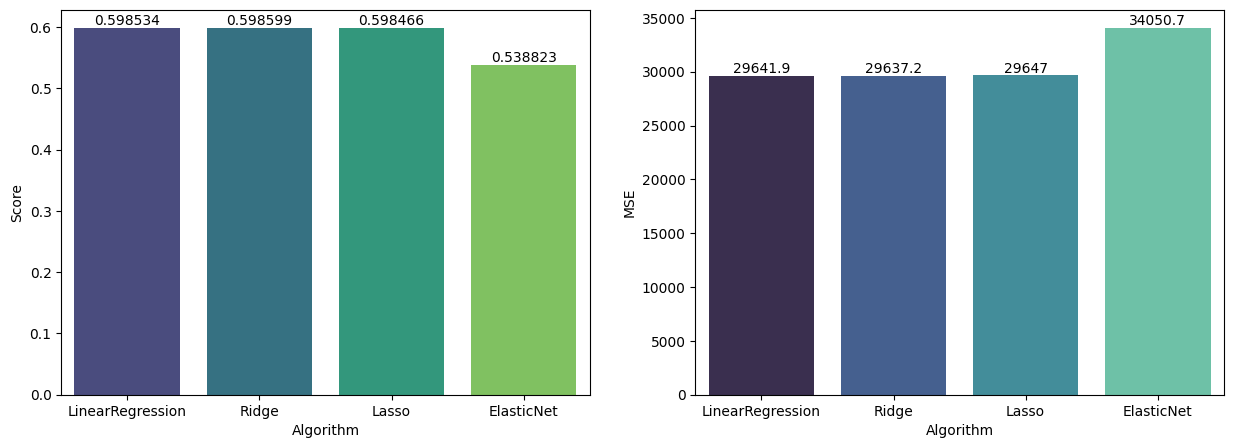

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.barplot(
    x='Algorithm',
    y='Score',
    data=algo_scores,
    ax=axs[0],
    palette='viridis',
    legend=False,
    hue='Algorithm'
)
for i in axs[0].containers:
    axs[0].bar_label(i,)
sns.barplot(
    x='Algorithm',
    y='MSE',
    data=algo_scores,
    ax=axs[1],
    palette='mako',
    legend=False,
    hue='Algorithm'
)
for i in axs[1].containers:
    axs[1].bar_label(i,)
plt.show()

In [36]:
for alg in tqdm(algos):
    alg = load(filename=f'{get_var_name(alg)}.joblib')

100%|██████████| 4/4 [00:00<00:00, 999.83it/s]
